In [1]:
import pandas as pd
pd.set_option('display.max_rows', 2000)
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import os
import sys
import inspect

# code to manage where are lunch the file
if str(os.getcwd()).split("/")[-1] == "notebooks":
    sys.path.insert(1, os.path.realpath(os.path.pardir))
    path_b = "../"
else:
    path_b ='./'
import config as c

In [2]:
windows = c.windows
number_crypto = c.number_cryptos
market_cap = c.market_cap

df = pd.read_csv(f"{path_b}data/processed/market_cap_crypto.csv", index_col=0)

df_close_price = pd.read_csv(f'{path_b}data/processed/close_price_crypto.csv', index_col=0)
df_close_price['date'] = pd.to_datetime(df_close_price.index)
df_close_price['date'] = df_close_price['date'].dt.date
df_close_price.index = df_close_price['date']
del df_close_price['date']

# processing part Data

In [3]:
## use market cap file

df_market_cap = pd.read_csv(f'{path_b}data/processed/crypto_date_marketcap_sorted_1e6.csv', index_col=0)


df_market_cap_first_20 = df_market_cap.iloc[:number_crypto]

#select last date
first_date = df_market_cap_first_20['first_date_marketcap'].tail(1).values

first_date_final = pd.to_datetime(first_date[0])

# TODO: change way to do it in the index
df_final_data = df_close_price.drop(df_close_price[df_close_price.index < first_date_final].index)
#print(df_final_data)
df_final_data = df_final_data[df_market_cap_first_20['crypto_name']]
df_final_data_return = df_final_data.pct_change().iloc[1:,:].fillna(0)
#df_final_data_return

/Users/guillaume/MyProjects/HECProject/qarm_2/project/venv/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [4]:
#Long Asset with Low Vol

df_vol = df_final_data_return.rolling(windows).std().fillna(0)[windows:]
df_vol.head(5)
#returns_vol_quantile = df_vol.T.apply(lambda x: pd.qcut(x, 5, labels=False, duplicates="drop"), axis=0).T

,peercoin,namecoin,litecoin,bitcoin,feathercoin,primecoin,ripple,nxt,dogecoin,omni,...,iota,mysterium,more-coin,zrcoin,bancor,numeraire,gxchain,funfair,status,ergo
date,,,,,,,,,,,,,,,,,,,,,
2017-10-28,0.066900,0.079699,0.071642,0.052731,0.119846,0.103425,0.065509,0.101760,0.082887,0.110968,...,0.106499,0.107352,0.118831,0.247391,0.068193,0.115045,0.153594,0.367784,0.148334,0.239892
2017-10-29,0.066816,0.079798,0.071639,0.052966,0.119796,0.102778,0.065448,0.100913,0.083782,0.110327,...,0.106459,0.107321,0.118652,0.240836,0.068085,0.111201,0.153352,0.365507,0.148332,0.235139
2017-10-30,0.066759,0.079580,0.071442,0.052946,0.124493,0.102814,0.065426,0.100904,0.083619,0.110467,...,0.106436,0.107307,0.118161,0.240535,0.067670,0.111766,0.153276,0.131823,0.148277,0.232825
2017-10-31,0.067656,0.079594,0.070712,0.053099,0.127033,0.102898,0.065433,0.100904,0.083611,0.110426,...,0.106517,0.110255,0.118147,0.240236,0.067664,0.112067,0.153211,0.113720,0.145217,0.218492
2017-11-01,0.067352,0.079664,0.068709,0.053205,0.127878,0.102634,0.065473,0.100827,0.083622,0.110492,...,0.106642,0.110919,0.118115,0.239763,0.067724,0.112343,0.153274,0.113027,0.145272,0.214804


In [5]:
returns_vol_quantile = df_vol.T.apply(lambda x: pd.qcut(x, 5, labels=False, duplicates="drop"), axis=0).T
returns_vol_quantile.head(5)

,peercoin,namecoin,litecoin,bitcoin,feathercoin,primecoin,ripple,nxt,dogecoin,omni,...,iota,mysterium,more-coin,zrcoin,bancor,numeraire,gxchain,funfair,status,ergo
date,,,,,,,,,,,,,,,,,,,,,
2017-10-28,0,0,0,0,3,2,0,1,0,2,...,2,2,3,4,0,2,4,4,4,4
2017-10-29,0,0,0,0,3,2,0,1,0,2,...,2,2,3,4,0,2,4,4,4,4
2017-10-30,0,0,0,0,3,2,0,1,0,2,...,2,2,3,4,0,2,4,3,4,4
2017-10-31,0,0,0,0,3,2,0,1,0,2,...,2,2,3,4,0,2,4,2,4,4
2017-11-01,0,0,0,0,3,2,0,1,0,2,...,2,2,3,4,0,2,4,2,4,4


In [6]:
for i in returns_vol_quantile.columns:
    returns_vol_quantile.loc[returns_vol_quantile[i] == 0, i] = 0.5 # First quantile for vol
    returns_vol_quantile.loc[returns_vol_quantile[i] == 1, i] = 0
    returns_vol_quantile.loc[returns_vol_quantile[i] == 2, i] = 0
    returns_vol_quantile.loc[returns_vol_quantile[i] == 3, i] = 0
    returns_vol_quantile.loc[returns_vol_quantile[i] == 4, i] = -0.5

## Low Vol part ##
returns_low_vol_quantile = returns_vol_quantile.replace(0.5,1)
returns_low_vol_quantile = returns_low_vol_quantile.replace(-0.5,0)
returns_low_vol_quantile['sum'] = returns_low_vol_quantile.sum(axis=1)

#better to do things => here Low Vol portfolio
# Do the same things about High vol
for i in tqdm(returns_low_vol_quantile.index):
    number = returns_low_vol_quantile['sum'].loc[i]
    for column in returns_low_vol_quantile.columns:
        returns_low_vol_quantile[column].loc[i] = returns_low_vol_quantile[column].loc[i] / number
del returns_low_vol_quantile['sum']

## High Vol part ##

returns_high_vol_quantile = returns_vol_quantile.replace(-0.5,1)
returns_high_vol_quantile = returns_high_vol_quantile.replace(0.5,0)
returns_high_vol_quantile['sum'] = returns_high_vol_quantile.sum(axis=1)

#better to do things => here Low Vol portfolio
# Do the same things about High vol
for i in tqdm(returns_high_vol_quantile.index):
    number = returns_high_vol_quantile['sum'].loc[i]
    for column in returns_high_vol_quantile.columns:
        returns_high_vol_quantile[column].loc[i] = returns_high_vol_quantile[column].loc[i] / number
del returns_high_vol_quantile['sum']

100%|██████████| 1468/1468 [01:20<00:00, 18.31it/s]


In [7]:
df_final_data_return = df_final_data_return.loc[returns_low_vol_quantile.index,:]
low_vol_return = np.multiply(df_final_data_return, returns_low_vol_quantile)
low_vol_perf = np.sum(low_vol_return,1)

high_vol_return = np.multiply(df_final_data_return, returns_high_vol_quantile)
high_vol_perf = np.sum(high_vol_return,1)

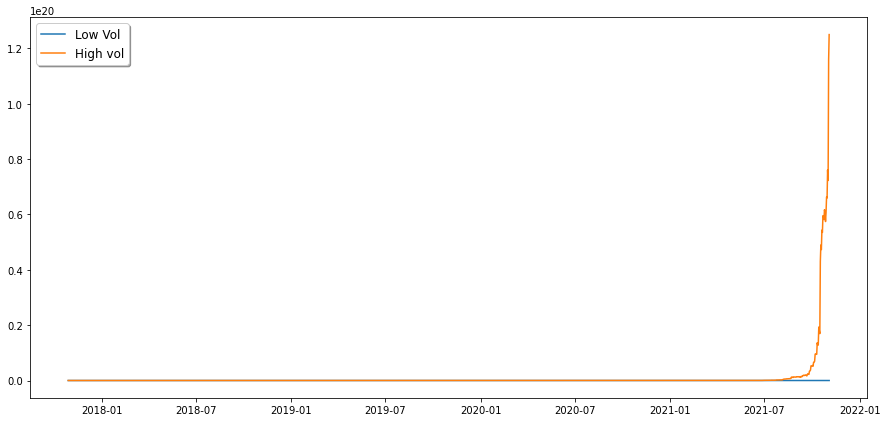

In [8]:
plt.figure(figsize=(15,7))

low_vol_perf.replace([np.inf, -np.inf], np.nan, inplace=True)
low_vol_perf.dropna(inplace=True)
low_vol_perf.iloc[0]=0
low_vol = (low_vol_perf+1).cumprod()*100
# low_vol.to_csv(f"../data/processed/Low_Vol_{number_crypto}_price.csv")

high_vol_perf.iloc[0]=0
high_vol = (high_vol_perf+1).cumprod()*100
# high_vol.to_csv(f"../data/processed/High_Vol_{number_crypto}_price.csv")


plt.plot(low_vol)
plt.plot(high_vol)
plt.legend(['Low Vol', 'High vol'],loc='upper left',fontsize='large',fancybox=True, shadow=True)
plt.show()